# 一维信号处理

**尺度缩放：**<br>
方法：均值中心化、最大最小归一化、标准化<br>
作用：消除尺度差异带来的不良的影响

**基线校正：**<br>
方法：一阶二阶导数、连续小波<br>
作用：扣除仪器背景或漂移对信号的影响


**平滑处理：**<br>
方法：移动平均、SG平滑<br>
作用：有效提高光谱信噪比、降低随机噪声的影响及降噪

**散射校正：**<br>
方法：多元散射校正(MSC)、标准正态变换(SNV)<br>
作用：消除由于颗粒分布不均及颗粒大小不同产生的散射对光谱的影响


(5, 751) (751, 5)


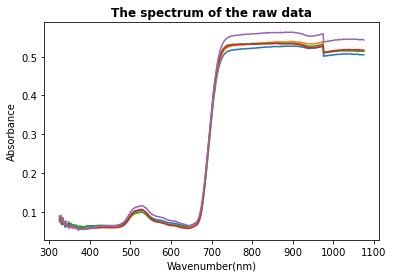

In [23]:
##引入库
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# 辅助内嵌画图命令
from scipy import signal
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')

##读入数据、预处理以及展示
#载入数据
data_path = 'data/intensity.csv' #数据
xcol_path = 'data/wavenumber.csv' #波长
data = np.loadtxt(open(data_path, 'rb'), dtype=np.float64, delimiter=',', skiprows=0)
xcol = np.loadtxt(open(xcol_path, 'rb'), dtype=np.float64, delimiter=',', skiprows=0)

print(data.shape, xcol.shape)
# 绘制MSC预处理后图片
plt.figure(500)
x_col = xcol  #数组逆序
y_col = np.transpose(data)
plt.plot(x_col, y_col)
plt.xlabel("Wavenumber(nm)")
plt.ylabel("Absorbance")
plt.title("The spectrum of the raw data",fontweight= "semibold",fontsize='large') 
plt.show()



In [24]:
def plot_data(Data_preprocess):    
    # 绘制预处理后的图片
    plt.figure(500)
    x_col = xcol[0:Data_preprocess.shape[1],:]  #数组逆序
    y_col = np.transpose(Data_preprocess)
    plt.plot(x_col, y_col)
    plt.xlabel("Wavenumber(nm)")
    plt.ylabel("Absorbance")
    plt.title("The spectrum of the preprocessed data",fontweight= "semibold",fontsize='large') 
    plt.show()

## 一、尺度缩放


### 1.1 标准化

含义：<br>
对数据进行量纲化处理，将数据变换为均值为0，标准差为1的分布，但并非是正态的

原理：<br>
调用sklearn.preprocessing中StandardScaler预处理函数函数中fit_transform拟合数据并进行标准化

fit ()：学习原始数据集中所有数据，并计算出平均值与标准差。<br>
fit_transform ()：学习原始数据集并返回标准化矩阵。<br>
fit_transform 的意思是先做一些计算，然后再做转换（比如从一些数据中计算列的平均值，然后替换缺失的值）


In [25]:
# 标准化代码
def SS(data):
    return StandardScaler().fit_transform(data.T).T

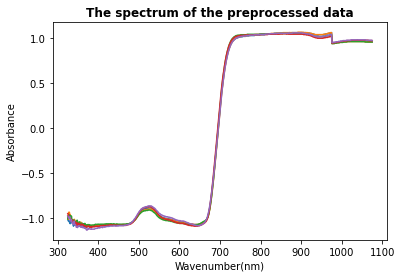

In [26]:
Data_preprocess = SS(data)
plot_data(Data_preprocess)

### 1.2 均值中心化：

含义： <br>
变量减去它的均值，可看成一个平移过程、将所有数据中心平移至（0，0）

原理：<br>
x_new=x-x_(平均值)

作用：<br>
增加样品光谱之间的差异，提高模型的稳健性和预测能力

In [27]:
# 均值中心化代码代码
def CT(data):
    for i in range(data.shape[0]):
        MEAN = np.mean(data[i])
        data[i] = data[i] - MEAN
    return data

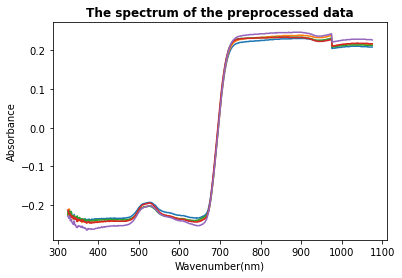

In [28]:
Data_preprocess = CT(data)
plot_data(Data_preprocess)

### 1.3 最大最小值归一化：

原理：<br>
x*=(x-x_min)/(x_max-x_min)

作用：<br>
去量纲，用线性化的方法将原始数据转换到[0,1]的范围，但没有改变数据分布

In [29]:
# 最大最小值归一化
def MMS(data):
    return MinMaxScaler().fit_transform(data.T).T

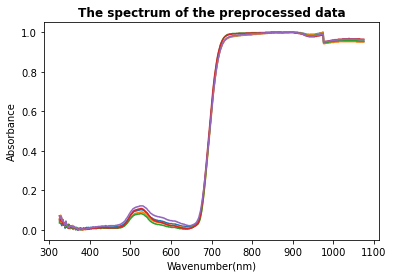

In [30]:
Data_preprocess = MMS(data)
plot_data(Data_preprocess)

## 二、基线校正

### 2.1 一阶二阶导数

利用差分法进行一阶和二阶导数的求解

In [31]:
# 一阶导数
def D1(data):
    n, p = data.shape
    Di = np.ones((n, p - 1))
    for i in range(n):
        Di[i] = np.diff(data[i])
    return Di

# 二阶导数
def D2(data):
    n, p = data.shape
    Di = np.ones((n, p - 2))
    for i in range(n):
        Di[i] = np.diff(np.diff(data[i]))
    return Di

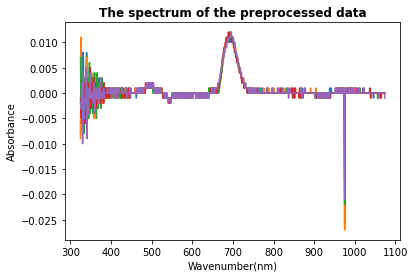

In [32]:
Data_preprocess = D1(data)
plot_data(Data_preprocess)

### 2.2 趋势校正(DT):

原理：
一种逐行变换，允许对波长进行行间转换，通过拟合每个光谱的二度多项式，可以校正与波长有关的散射效应趋势校正，可以在标准正态变换后使用，以规避任何曲线型<br>

作用：
解释基线移动和曲线的变换，校正基线漂移，可在标准正态变换后使用趋势校正

In [33]:

# 趋势校正(DT)代码
def DT(data):
    x = np.asarray(range(350, 1101), dtype=np.float32)
    out = np.array(data)
    l = LinearRegression()
    for i in range(out.shape[0]):
        l.fit(x.reshape(-1, 1), out[i].reshape(-1, 1))
        k = l.coef_
        b = l.intercept_
        for j in range(out.shape[1]):
            out[i][j] = out[i][j] - (j * k + b)
    return out



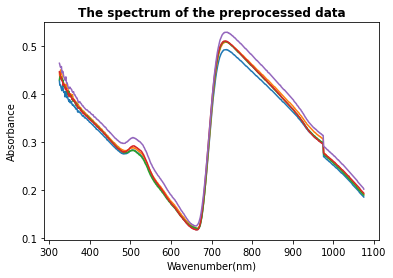

In [34]:
Data_preprocess = DT(data)
plot_data(Data_preprocess)

## 三、平滑处理

### 3.1 移动平均：

含义：<br>
平滑窗口在数据上移动求平均，从而对数据进行去噪

作用：<br>
提高光谱平滑度，降低噪音的干扰

In [35]:


# 移动平均平滑代码
# WSZ是窗口宽度，是奇数，越大，越光滑
def MA(a, WSZ=21):
    for i in range(a.shape[0]):
        out0 = np.convolve(a[i], np.ones(WSZ, dtype=int), 'valid') / WSZ # WSZ是窗口宽度，是奇数
        r = np.arange(1, WSZ - 1, 2)
        start = np.cumsum(a[i, :WSZ - 1])[::2] / r
        stop = (np.cumsum(a[i, :-WSZ:-1])[::2] / r)[::-1]
        a[i] = np.concatenate((start, out0, stop))
    return a



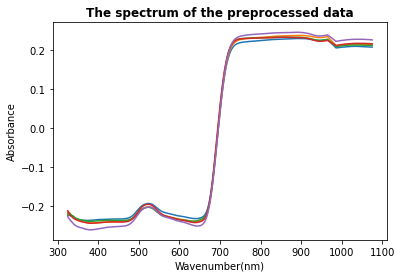

In [36]:
Data_preprocess = MA(data)
plot_data(Data_preprocess)

### 3.2 SG平滑

含义：<br>
一种在时域内基于局域多项式最小二乘拟合的滤波方法，在滤除噪声的同时确保信号的形状和宽度不变、

作用：<br>
移动平均平滑的改进，提高光谱平滑度，降低噪音的干扰

In [37]:
# Savitzky-Golay平滑滤波代码
def SG(data, w=21, p=3):
#w：窗口长度，越大，平滑效果越明显；
#p：多项式拟合的阶数，越小，平滑效果越明显
    return signal.savgol_filter(data, w, p)

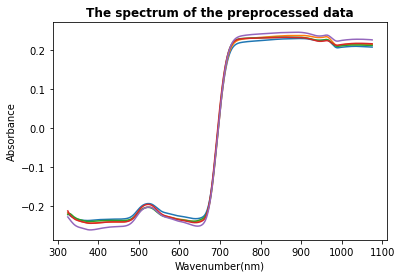

In [38]:
Data_preprocess = SG(data)
plot_data(Data_preprocess)

## 四、散射校正

### 4.1 标准正态变换（SNV）


原理：
（原始光谱-光谱平均值）/标准偏差

作用：
用于消除由于样本颗粒大小、表面散射及光程变换对漫反射的影响减少散射、粒度、多重共线性变化在整个近红外光谱中的乘法效应



In [39]:
# 标准正态变换代码
def SNV(data):
    m = data.shape[0]
    n = data.shape[1]
    #print(m, n)  #
    # 求标准差
    data_std = np.std(data, axis=1)  # 每条光谱的标准差
    # 求平均值
    data_average = np.mean(data, axis=1)  # 每条光谱的平均值
    # SNV计算
    data_snv = [[((data[i][j] - data_average[i]) / data_std[i]) for j in range(n)] for i in range(m)]
    return  np.array(data_snv)


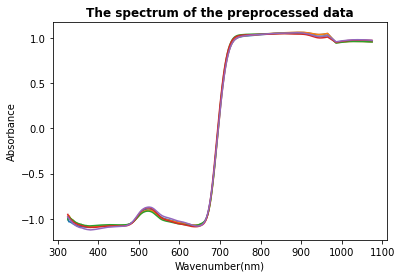

In [40]:
Data_preprocess = SNV(data)
plot_data(Data_preprocess)

### 4.2 多元散射变换（MSC）

作用：
基本与SNV相同，消除由于样本颗粒分布不均匀以及大小不同产生的散射对光谱的影响

In [41]:
# MSC(数据)
def MSC(Data):
    # 计算平均光谱
    n, p = Data.shape
    msc = np.ones((n, p))

    for j in range(n):
        mean = np.mean(Data, axis=0)

    # 线性拟合
    for i in range(n):
        y = Data[i, :]
        l = LinearRegression()
        l.fit(mean.reshape(-1, 1), y.reshape(-1, 1))
        k = l.coef_
        b = l.intercept_
        msc[i, :] = (y - b) / k
    return msc



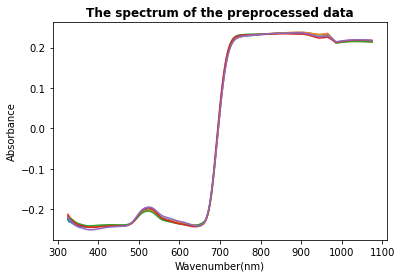

In [42]:
Data_preprocess = MSC(data)
plot_data(Data_preprocess)

## 数据预处理和保存

In [43]:

#数据预处理、可视化和保存
datareprocessing_path = './data//dataMSC.csv' #波长
Data_preprocess = MSC(data)  #更改函数名得到不同的预处理

#保存预处理后的数据
np.savetxt(datareprocessing_path, Data_preprocess, delimiter=',')